In [64]:
import os
import numpy as np 
import pandas as pd
from plot_params import * 
from math import sqrt
from tqdm import tqdm
from joblib import Parallel, delayed
from scipy.stats import qmc, norm, f, truncnorm, normaltest

In [65]:
def check_inside_mandlebrot(i, c, corr):
    """
    Checks whether the complex number c lies inside the mandelbrot set or not.
    Returns 1 if it does, 0 if it does not.
    If c is generated by importance sampling and
    lies inside the set the return value is corrected 
    """
    z = 0 + 0j
    for _ in range(i):
        z = z ** 2 + c
        if abs(z) > 2:
            return 0
    if corr:
        return 1/4/norm.pdf(np.imag(c),loc=0, scale=0.5)
    else:
        return 1

def mandlebrot_area(i, s, sampling_function):
    """
    Returns the area of the mandelbrot set. 
    Generates s complex numbers and determines how many lie inside of the set.
    The fraction of points inside the set is then 
    multiplied by the size of the sampling box to obtain the area.
    """
    random_complex_numbers = sampling_function(s)
    in_mandlebrot = 0
    corr = False
    if sampling_function.__name__ == 'importance_sampling':
        corr = True
    for z in random_complex_numbers:
        in_mandlebrot += check_inside_mandlebrot(i, z, corr)
    area = in_mandlebrot / s * area_box
    return area

def uniform_samples(n):
    """ 
    Returns n complex numbers using the np.random.uniform function.
    """
    real = np.random.uniform(real_min, real_max, size=n)
    imaginary = np.random.uniform(imag_min, imag_max, size=n) * 1j
    random_complex_numbers = real + imaginary
    return random_complex_numbers

def get_truncated_normal(mean, std, low, upp, size):
    """
    Returns size samples form a truncated version of the normal distribution.
    """
    truncated = truncnorm(
        (low - mean) / std, (upp - mean) / std, loc=mean, scale=std
    )
    return truncated.rvs(size)

def importance_sampling(n):
    """
    Returns n complex random numbers.
    The real values have been drawn from the uniform distribution.
    The imaginary values have been drawn from a normal distribution 
    with mean 0 and sigma 0.5.
    """
    real = np.random.uniform(real_min, real_max, size=n)
    imaginary = get_truncated_normal(0, 0.5, imag_min, imag_max, size=n) * 1j
    random_complex_numbers = real + imaginary
    return random_complex_numbers

def OLHC_samples(n):
    """
    Returns n random complex numbers generated by orthogonal sampling.
    """
    major = int(sqrt(n))
    samples = major * major
    scale = 4 / samples
    xlist = np.zeros((major, major))
    ylist = np.zeros((major, major))
    reals = []
    imags = []
    m = 0
    for i in range(major):
        for j in range(major):
            xlist[i][j] = m
            ylist[i][j] = m
            m += 1
    for i in range(major):
        xlist[i] = np.random.permutation(xlist[i])
        ylist[i] = np.random.permutation(ylist[i])
    for i in range(major):
        for j in range(major):
            x = -2 + scale * (xlist[i][j] + np.random.rand())
            y = -2 + scale * (ylist[j][i] + np.random.rand())
            reals.append(x)
            imags.append(y)

    return np.array(reals) + np.array(imags) * 1j

def LHC_samples(n):
    """
    Returns n random complex numbers using scipy's latin hypercube method.
    """
    sampler = qmc.LatinHypercube(d=2)
    sample = sampler.random(n=n) 
    sample = qmc.scale(sample, [real_min, imag_min], [real_max, imag_max])
    reals = sample[:, 0]
    imags = sample[:, 1]
    samples = reals + imags * 1j
    return samples


def f_test(data_X, data_Y):
    '''H0: var(x)=var(y).
    returns the p value of the test
    if p > significance level, then H0 is accepted
    this test is sensitive to data_x and data_y '''
    var_x = np.var(data_X)
    var_y = np.var(data_Y)
    n_x = len(data_X)
    n_y = len(data_Y)
    if var_x/var_y > var_y/var_x:
        f_stat = var_x/var_y
        df1 = n_x - 1
        df2 = n_y - 1
    else:
        f_stat = var_y/var_x
        df1 = n_y - 1
        df2 = n_x - 1
    p_value = f.sf(f_stat, df1, df2)
    return p_value

In [66]:
# see how fast the area converges based on the number of iterations

class Convergence():
    """
    Class that calculates the area of the mandelbrot set based on 
    given values for s and i and a given sampling function.
    """
    def __init__(self, max_i, max_s, n_runs, rand_num_generator):
        """
        Initializes by calculating the area with the maximun values for s and i.
        Saves the result of this initial run for comparison to other runs.
        """
        self.max_i = max_i
        self.max_s = max_s
        self.n_runs = n_runs
        self.rand_num_generator = rand_num_generator
        self.areas = 0
        self.max_mean, self.max_std = self.determine_area(max_i, max_s)
        self.means = []
        self.stds = []
        print(
            f'best estimate: {self.max_mean}',
            f'with a standard deviation of {self.max_std}',
            f'with i = {max_i}, s = {max_s}'
        )

    def determine_area(self, i, s):
        """
        Returns the mean and standard deviation 
        of the area of the mandelbrot set.
        The mean and variance are based on calculating the area 'n_runs' times. 
        """
        areas = Parallel(n_jobs=n_cores)(delayed(mandlebrot_area)(
            i, s, self.rand_num_generator) for _ in range(self.n_runs))
        areas = np.array(areas)
        self.areas = areas
        mean = areas.mean()
        var = ((areas - mean) ** 2).sum() / (self.n_runs * (self.n_runs - 1))
        std = sqrt(var)
        return mean, std
    
    def diff_with_max(self, i, s):
        """
        Returns the mean and area of mandelbrot set, 
        using s samples and i iterations alongside the difference of this result 
        compared to the initial run with max_i and max_s, and the total 
        standard deviation.
        """
        mean, std = self.determine_area(i, s)
        mean_diff = mean - self.max_mean
        std_diff = std + self.max_std
        return mean_diff, std_diff, mean, std

In [80]:
# sampling area
real_min = -2
real_max = 2
imag_min = -2
imag_max = 2
area_box = (real_max - real_min) * (imag_max - imag_min)

# settings 
n_cores = os.cpu_count()
n_runs = 250
min_i = 10
max_i = 500
n_different_i = 15
min_s = 1000
max_s = 100000
n_different_s = 15

# looping lists based on the settings
i_values = np.linspace(max_i, min_i, n_different_i, dtype=int)
s_values = np.linspace(sqrt(max_s), sqrt(min_s), n_different_s, dtype=int) ** 2
max_i = i_values[0]
min_i = i_values[-1]
max_s = s_values[0]
min_s = s_values[-1]

In [68]:
# lists to save the results
areas_min_all_results = []
areas_max_all_results = []
stds_max_all_results = []
mean_s_all_results = []
stds_s_all_results = []
means_diff_i_all_results = []
stds_diff_i_all_results = []
means_diff_s_all_results = []
stds_diff_s_all_results = []

# loop over all different sampling functions
sampling_fuctions = [
    uniform_samples, 
    LHC_samples, 
    OLHC_samples, 
    importance_sampling
]
for rand_num_generator in sampling_fuctions:

    # create arrays to hold the results
    means_s = np.zeros(n_different_s)
    stds_s = np.zeros(n_different_s)
    means_diff_i = np.zeros(n_different_i)
    stds_diff_i = np.zeros(n_different_i)
    means_diff_s = np.zeros(n_different_s)
    stds_diff_s = np.zeros(n_different_s)

    # initialize the class and save results calculated with max_i and max_s
    con = Convergence(max_i, max_s, n_runs, rand_num_generator)
    areas_max_all_results.append(con.areas)
    stds_max_all_results.append(con.max_std)
    stds_s[0] = con.max_std
    means_s[0] = con.max_mean

    # do a run with the minimun values of i and s and save the results
    con.determine_area(max_i, min_s)
    areas_min_all_results.append(con.areas)

    # hold i at the maximun value and loop over different values for s
    # calculate the mean and std for every s value alongside the difference
    # with the maximum value
    desc = rand_num_generator.__name__ + ' s convergence'
    for m in tqdm(range(1, n_different_s), desc=desc):
        s = s_values[m]
        means_diff_s[m], stds_diff_s[m], means_s[m], stds_s[m] =(
            con.diff_with_max(max_i, s)
        )
    # hold s at the maximun value and loop over different values for i
    # calculate the differenc with the maximun value for all i values
    desc = rand_num_generator.__name__ + ' i convergence'
    for m in tqdm(range(1, n_different_i), desc=desc):
        i = i_values[m]
        means_diff_i[m], stds_diff_i[m], _, _ = con.diff_with_max(i, max_s)

    # fill the lists with the results
    mean_s_all_results.append(means_s)
    stds_s_all_results.append(stds_s)
    means_diff_i_all_results.append(means_diff_i)
    stds_diff_i_all_results.append(stds_diff_i)
    means_diff_s_all_results.append(means_diff_s)
    stds_diff_s_all_results.append(stds_diff_s)

best estimate: 1.556473469387755 with a standard deviation of 0.006540508683737368 with i = 100, s = 4900


uniform_samples i convergence: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s]


best estimate: 1.5487346938775508 with a standard deviation of 0.006176069735208474 with i = 100, s = 4900


LHC_samples i convergence: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


best estimate: 1.5449795918367346 with a standard deviation of 0.0015713924290472988 with i = 100, s = 4900


OLHC_samples i convergence: 100%|██████████| 9/9 [00:14<00:00,  1.57s/it]


In [69]:
# save the results for possible later use
for lst, name in zip(
    [
        areas_min_all_results,
        areas_max_all_results,
        stds_max_all_results,
        mean_s_all_results,
        stds_s_all_results,
        means_diff_i_all_results,
        stds_diff_i_all_results,
        means_diff_s_all_results,
        stds_diff_s_all_results
    ],
    [
        'areas_min_all_results',
        'areas_max_all_results',
        'stds_max_all_results',
        'mean_s_all_results',
        'stds_s_all_results',
        'means_diff_i_all_results',
        'stds_diff_i_all_results',
        'means_diff_s_all_results',
        'stds_diff_s_all_results'
    ]):
    np.save(f'results/{name}', np.array(lst))

In [81]:
# load all results 

areas_min_all_results = np.load('final_results/areas_min_all_results.npy')
areas_max_all_results = np.load('final_results/areas_max_all_results.npy')
stds_max_all_results = np.load('final_results/stds_max_all_results.npy')
mean_s_all_results = np.load('final_results/mean_s_all_results.npy')
stds_s_all_results = np.load('final_results/corrected_stds_s_all_results.npy')
means_diff_i_all_results = np.load('final_results/means_diff_i_all_results.npy')
stds_diff_i_all_results = np.load('final_results/corrected_stds_diff_i_all_results.npy')
means_diff_s_all_results = np.load('final_results/means_diff_s_all_results.npy')
stds_diff_s_all_results = np.load('final_results/corrected_stds_diff_s_all_results.npy')

Uniform is normal distributed with p=0.2788788522797494
Latin hypercube is normal distributed with p=0.7443274899463241
Orthogonal is normal distributed with p=0.5065049247742501
Importance sampling is normal distributed with p=0.8000709043296046


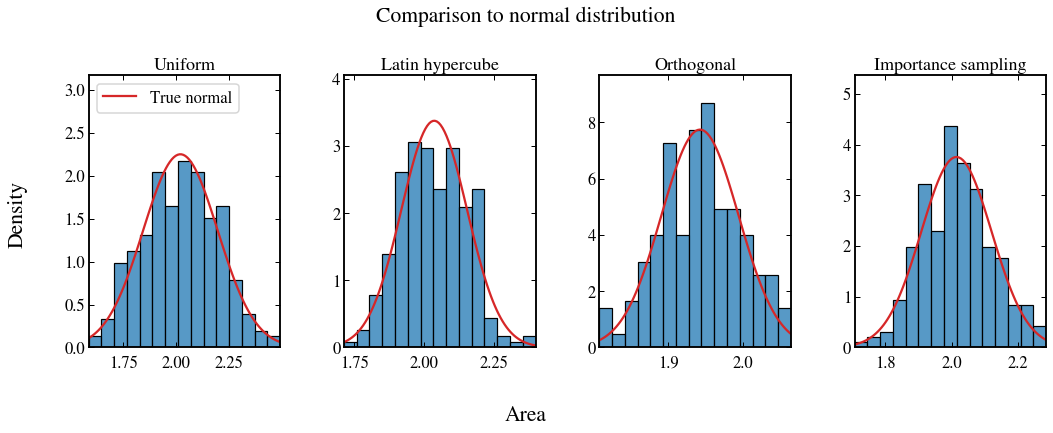

In [82]:
# plot to visually see if the areas generated using the minimum values 
# for i and s follow a normal distribution
sampling_names = [
    'Uniform', 
    'Latin hypercube', 
    'Orthogonal', 
    'Importance sampling'
]
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
plt.suptitle('Comparison to normal distribution')
fig.supxlabel('Area')
fig.supylabel('Density')

for ax, areas, name in zip(axs, areas_min_all_results, sampling_names):
    x = np.linspace(min(areas), max(areas), 100)
    y = norm.pdf(x, areas.mean(), areas.std())
    ax.plot(x, y, label='True normal', color='tab:red')
    hist = np.histogram(areas, density=True, bins=15)
    ax.set(xlim=(min(areas), max(areas)), ylim =(0, max(hist[0])+1), ylabel=' ', title=name)
    sns.histplot(areas, stat='density', ax=ax, bins=15)

    # perform a normal test to see if the results follow a normal distribution
    stat, p = normaltest(areas)
    if p > 0.05:
        print(f'{name} is normal distributed with p={p}')
    else:
        print(f'{name} is NOT normal distributed with p={p}')

axs[0].legend(loc=2)
axs[0].set_title('Uniform')
axs[1].set_title('Latin hypercube')
axs[2].set_title('Orthogonal')
fig.tight_layout()
plt.savefig('figures/normal.pdf')
plt.show()

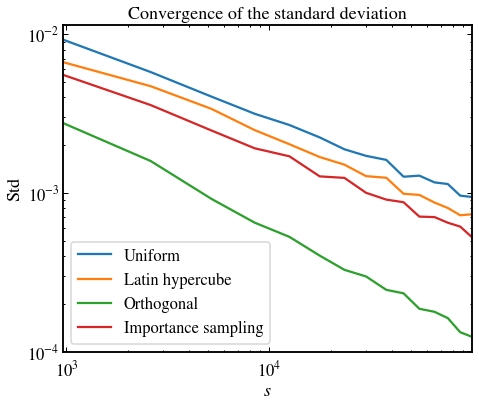

In [89]:
# plot showing the convergence of the std under varying s
for stds, name in zip(stds_s_all_results, sampling_names):
    plt.plot(s_values, stds, label=name)
plt.legend()
plt.title('Convergence of the standard deviation')
plt.ylabel('Std')
plt.xlabel('$s$')
plt.xlim(min_s, max_s)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.savefig('figures/std_conv.pdf')
plt.show()

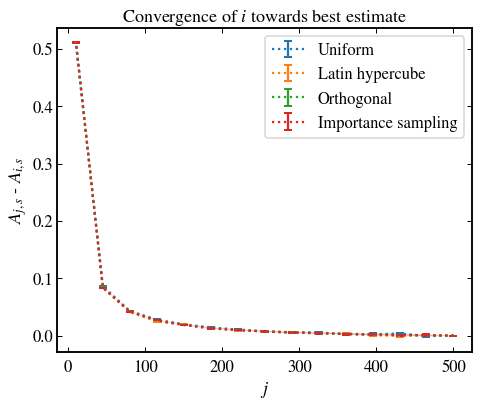

In [95]:
# plot shwoing the convegence towards the best estimate of the area 
# under varying i
for means, stds, name in zip(
    means_diff_i_all_results, 
    stds_diff_i_all_results, 
    sampling_names
):
    plt.errorbar(
        i_values, 
        means, 
        stds, 
        fmt=':', 
        capsize=4, 
        capthick=2, 
        label=name
    )
    plt.fill_between(i_values, means - stds, means + stds, alpha=0.2)
plt.legend()
plt.title('Convergence of $i$ towards best estimate')
plt.xlabel('$j$')
plt.ylabel('$A_{j, s}$ - $A_{i, s}$')
plt.tight_layout()
plt.savefig('figures/area_conv_i.pdf')
plt.show()

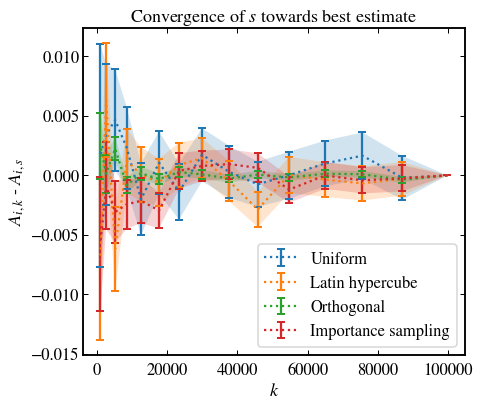

In [94]:
# plot shwoing the convegence towards the best estimate of the area 
# with varying s
for means, stds, name in zip(
    means_diff_s_all_results, 
    stds_diff_s_all_results, 
    sampling_names
):
    plt.errorbar(
        s_values, 
        means, stds, 
        fmt=':', 
        capsize=4, 
        capthick=2, 
        label=name
    )
    plt.fill_between(s_values, means - stds, means + stds, alpha=0.2)
plt.legend()
plt.title('Convergence of $s$ towards best estimate')
plt.xlabel('$k$')
plt.ylabel('$A_{i, k}$ - $A_{i, s}$')
plt.tight_layout()
plt.savefig('figures/area_conv_s.pdf')
plt.show()

In [92]:
# determine the 95% confidence interval
Z_value = 1.96
intervals = []
for areas, stds, name in zip(
    areas_max_all_results, 
    stds_max_all_results, 
    sampling_names
):
    sample_mean = np.mean(areas)
    interval = Z_value * stds
    interval_str = np.format_float_positional(
        interval, 
        precision=2, 
        fractional=False
    )
    sample_mean_str = np.format_float_positional(
        sample_mean, 
        precision=len(interval_str) - 1,
        fractional=False
    )
    intervals.append(f'{sample_mean_str} ± {interval_str}')
    print(
        f'95% confidence gives range {sample_mean}',
        f'± {interval} using {name}'
    )

# print the result to a latex table
df = pd.DataFrame({
    'Sampling function': sampling_names,
    '95% confidence interval': intervals
})
print()
print(df.to_latex(index=False))

95% confidence gives range 1.5138298349623458 ± 9.210650882912994e-05 using Uniform
95% confidence gives range 1.5147764781285051 ± 7.175738024488744e-05 using Latin hypercube
95% confidence gives range 1.5143547508412114 ± 1.2085380547202091e-05 using Orthogonal
95% confidence gives range 1.5147662510035589 ± 5.119743621113032e-05 using Importance sampling

\begin{tabular}{ll}
\toprule
  Sampling function & 95\% confidence interval \\
\midrule
            Uniform &      1.51383 ± 0.000092 \\
    Latin hypercube &     1.514776 ± 0.000072 \\
         Orthogonal &     1.514355 ± 0.000012 \\
Importance sampling &     1.514766 ± 0.000051 \\
\bottomrule
\end{tabular}



In [96]:
# f-test to see if the variances differ significantly
pairs = []
p_values = []
variance_bool = []
alpha = 0.05
for i in range(4):
    for j in range(4):
        if i == j or i > j:
            continue
        p = f_test(areas_max_all_results[i], areas_max_all_results[j])
        name_1 = sampling_names[i]
        name_2 = sampling_names[j]
        pairs.append(f'{name_1} & {name_2}')
        p_values.append(p)
        if p > alpha:
            variance_bool.append(True)
            print(f'{name_1} and {name_2} have same variance with p = {p}')
        else:
            variance_bool.append(False)
            print(
                f'{name_1} and {name_2} do NOT have same variance with p = {p}'
            )
# print the results to a latex table
print()
df = pd.DataFrame({
    'Pair':pairs, 
    'p-value': p_values, 
    'Same variance':variance_bool
})
print(df.to_latex(index=False))

Uniform and Latin hypercube do NOT have same variance with p = 4.5128041651891265e-05
Uniform and Orthogonal do NOT have same variance with p = 7.985320811231393e-149
Uniform and Importance sampling do NOT have same variance with p = 1.0255557094834091e-19
Latin hypercube and Orthogonal do NOT have same variance with p = 5.3779664851861095e-123
Latin hypercube and Importance sampling do NOT have same variance with p = 6.72261321576771e-08
Orthogonal and Importance sampling do NOT have same variance with p = 2.648910322427965e-89

\begin{tabular}{lrl}
\toprule
                                 Pair &       p-value &  Same variance \\
\midrule
            Uniform \& Latin hypercube &  4.512804e-05 &          False \\
                 Uniform \& Orthogonal & 7.985321e-149 &          False \\
        Uniform \& Importance sampling &  1.025556e-19 &          False \\
         Latin hypercube \& Orthogonal & 5.377966e-123 &          False \\
Latin hypercube \& Importance sampling &  6.722613e